In [21]:
from defense.generate_dataset import generate_defense_set, generate_testset
import tensorflow as tf
import pandas as pd
import numpy as np
from art.estimators.classification import TensorFlowV2Classifier
from evaluation_metric import evaluate_metric

# TRAIN DETECTOR

In [22]:
# from defense.generate_dataset import generate_dataset

samples = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=["Unnamed: 0"])
samples = samples.iloc[np.where(y_samples.label_normal == 0)[0]]
y_samples = y_samples.iloc[np.where(y_samples.label_normal == 0)[0]]

fsgm_samples = pd.read_csv("NSL-KDD/samples/attack/X_FSGM_train.csv").drop(columns=["Unnamed: 0"])
bim_samples = pd.read_csv("NSL-KDD/samples/attack/X_BIM_train.csv").drop(columns=["Unnamed: 0"])
jsma_samples = pd.read_csv("NSL-KDD/samples/attack/X_JSMA_train.csv").drop(columns=["Unnamed: 0"])
deepfool_samples = pd.read_csv("NSL-KDD/samples/attack/X_DeepFool_train.csv").drop(columns=["Unnamed: 0"])

full_features = samples.columns
shap_importance_df = pd.read_csv("NSL-KDD/samples/shap_importance.csv").drop(columns=["Unnamed: 0"])
selected_features = shap_importance_df.loc[shap_importance_df['shap_importance'] > 0]['column_name'].values
shap_importance_feature_values = shap_importance_df.loc[shap_importance_df['shap_importance'] > 0]['shap_importance'].values
selected_features = [i for i in selected_features if 'protocol_type' not in i and 'service' not in i and 'flag' not in i]

In [ ]:
import tensorflow as tf
dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")
fgsm_pred = dnn.predict(fsgm_samples)
bim_pred = dnn.predict(bim_samples)
jsma_pred = dnn.predict(jsma_samples)
deepfool_pred = dnn.predict(deepfool_samples)
fsgm_samples = fsgm_samples.iloc[np.where(np.argmax(fgsm_pred, axis=1)==0)[0]]
bim_samples = bim_samples.iloc[np.where(np.argmax(bim_pred, axis=1)==0)[0]]
jsma_samples = jsma_samples.iloc[np.where(np.argmax(jsma_pred, axis=1)==0)[0]]
deepfool_samples = deepfool_samples.iloc[np.where(np.argmax(deepfool_pred, axis=1)==0)[0]]

In [25]:
from imblearn.over_sampling import SMOTE

defense_data = generate_defense_set(
    samples,
    fsgm_samples,
    bim_samples,
    jsma_samples,
    deepfool_samples,
    selected_features,
    shap_importance_feature_values,
    36
)

X_Defenes_Set = defense_data.drop(columns=['label'])
y_Defense_Set = defense_data['label']

print("Defense Set")
print(y_Defense_Set.value_counts())

balance_defense = SMOTE(sampling_strategy={1:67583})

X_Defenes_Set, y_Defense_Set = balance_defense.fit_resample(X_Defenes_Set, y_Defense_Set)

from sklearn.model_selection import train_test_split
x_defense_train, x_defense_test, y_defense_train, y_defense_test = train_test_split(
    X_Defenes_Set,
    y_Defense_Set,
    test_size=0.3,
)

print("On defense Train")
print(y_defense_train.value_counts())

print("On defense test")
print(y_defense_test.value_counts())

x_defense_train = np.reshape(x_defense_train, (x_defense_train.shape[0], x_defense_train.shape[1], 1))
x_defense_test = np.reshape(x_defense_test, (x_defense_test.shape[0], x_defense_test.shape[1], 1))
y_defense_train = pd.get_dummies(y_defense_train)*1
y_defense_test = pd.get_dummies(y_defense_test)*1

Defense Set
label
0    67583
1     9659
Name: count, dtype: int64
On defense Train
label
0    47389
1    47227
Name: count, dtype: int64
On defense test
label
1    20356
0    20194
Name: count, dtype: int64


In [26]:
def create_cnn(n_features):
    ae_detector_dnn = tf.keras.Sequential(
        layers=[
            tf.keras.layers.Convolution1D(2048, 3, padding='same', activation='relu', input_shape=(n_features,1)),
            tf.keras.layers.MaxPooling1D(pool_size=4),
            tf.keras.layers.Convolution1D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax'),
        ]
    )
    
    ae_detector_dnn.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    return ae_detector_dnn

ae_detector_cnn = create_cnn(x_defense_train.shape[1])
ae_detector_cnn.fit(x_defense_train, y_defense_train, epochs=2, batch_size=1024)

Epoch 1/2
93/93 [==============================] - 234s 2s/step - loss: 0.1399 - accuracy: 0.9459
Epoch 2/2
93/93 [==============================] - 239s 3s/step - loss: 0.0579 - accuracy: 0.9811


# EVALUATE

RQ1: on test-set from defense data

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def evaluate_metric_bin(y_pred, y_true):

    y_pred_ = np.argmax(y_pred, axis=1)
    y_true_ = np.argmax(y_true, axis=1)
    
    return {
        "confusion_matrix": confusion_matrix(y_true=y_true_, y_pred=y_pred_, labels=[0,1]),
        "accuracy_score": accuracy_score(y_true=y_true_, y_pred=y_pred_),
        "precision_score": precision_score(y_true=y_true_, y_pred=y_pred_),
        "recall_score": recall_score(y_true=y_true_, y_pred=y_pred_),
        "f1_score": f1_score(y_true=y_true_, y_pred=y_pred_)
    }

In [29]:
evaluate_metric_bin(y_pred=ae_detector_cnn.predict(x_defense_train), y_true=y_defense_train)

2957/2957 [==============================] - 38s 13ms/step


{'confusion_matrix': array([[47265,   124],
        [  394, 46833]]),
 'accuracy_score': 0.994525238860235,
 'precision_score': 0.9973592861554188,
 'recall_score': 0.991657314671692,
 'f1_score': 0.9945001274101758}

In [30]:
evaluate_metric_bin(y_pred=ae_detector_cnn.predict(x_defense_test), y_true=y_defense_test)

1268/1268 [==============================] - 18s 14ms/step


{'confusion_matrix': array([[20146,    48],
        [  170, 20186]]),
 'accuracy_score': 0.9946239210850801,
 'precision_score': 0.997627755263418,
 'recall_score': 0.9916486539595205,
 'f1_score': 0.9946292190194629}

RQ2: on random test set

In [ ]:
# from art.attacks.evasion.fast_gradient import FastGradientMethod
# from art.attacks.evasion.iterative_method import BasicIterativeMethod
# from art.attacks.evasion.saliency_map import SaliencyMapMethod
# from art.attacks.evasion.carlini import CarliniL2Method
# from art.attacks.evasion.deepfool import DeepFool

# def generate_testset_1(classifier, test_samples: pd.DataFrame, y_test_samples: pd.DataFrame, selected_features: list, n_features: int = 20, random_mode: bool= False):
#     import random
#     import copy
#     full_features = test_samples.columns
#     top_n_features = selected_features[:n_features]
    
#     index_number_n_features = [list(full_features).index(num) for num in top_n_features]
    
#     adversarial_algs = {
#         "FSGM": FastGradientMethod(estimator=classifier, eps=0.2),
#         "BIM": BasicIterativeMethod(estimator=classifier, eps=0.2, max_iter=100, batch_size=32),
#         "JSMA": SaliencyMapMethod(classifier=classifier,theta=0.1,gamma=1, batch_size=1),
#         "DeepFool": DeepFool(classifier=classifier, max_iter=100, epsilon=0.000001, nb_grads=10, batch_size=1),
#     }
#     return_df = test_samples.values
#     y_return = []
    
#     alg_namelist = list(adversarial_algs.keys())
    
#     np.random.seed(142)
    
#     for i in range(len(return_df)):
#         alg = np.random.choice(alg_namelist, p=[0.25,0.25,0.25,0.25])
#         ex = return_df[i]
#         ex = ex.reshape(1,ex.shape[0])
#         adversarial_algs[alg].generate(x=ex)
#         return_df[i, index_number_n_features] = ex[0,index_number_n_features]
#         y_return.append(1)

    
#     return_df = pd.DataFrame(return_df, columns=full_features)
    
#     return return_df, y_return

# dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")

# X_train = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=['Unnamed: 0'])
# y_train = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=['Unnamed: 0'])
# X_test = pd.read_csv("NSL-KDD/X_test.csv").drop(columns=['Unnamed: 0'])
# y_test = pd.read_csv("NSL-KDD/y_test.csv").drop(columns=['Unnamed: 0'])


# loss_object = tf.keras.losses.CategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# dnn_model = TensorFlowV2Classifier(
#     model=dnn,
#     loss_object=loss_object,
#     optimizer=optimizer,
#     nb_classes=5,
#     input_shape=X_train.shape
# )

# test_samples = X_test.sample(n=5000)
# y_test_samples = y_test.iloc[test_samples.index]
# test_samples = test_samples.iloc[np.where(y_test_samples.label_normal != 1)[0]]
# y_test_samples = y_test_samples.iloc[np.where(y_test_samples.label_normal != 1)[0]]
# ae_data, label_ae_data = generate_testset_1(
#     dnn_model,
#     test_samples,
#     y_test_samples,
#     selected_features,
#     36
# )
# ae_data.to_csv("NSL-KDD/defense/train-test/ae_x_train.csv")
# pd.DataFrame(label_ae_data, columns=['label']).to_csv("NSL-KDD/defense/train-test/ae_y_train.csv")

In [31]:
X_Random_Test_Set = pd.read_csv("NSL-KDD/defense/random-test-set/X_Random_Test_Set.csv").drop(columns=["Unnamed: 0"])
y_Random_Test_Set = pd.read_csv("NSL-KDD/defense/random-test-set/y_Random_Test_Set.csv").drop(columns=["Unnamed: 0"])
true_label = pd.get_dummies(y_Random_Test_Set, columns=['label'])*1
X_Random_Test_Set = X_Random_Test_Set[selected_features[:40]]
X_Random_Test_Set = np.reshape(X_Random_Test_Set, (X_Random_Test_Set.shape[0], X_Random_Test_Set.shape[1], 1))
evaluate_metric_bin(y_pred=ae_detector_cnn.predict(X_Random_Test_Set), y_true=true_label)

133/133 [==============================] - 2s 13ms/step


{'confusion_matrix': array([[2755,  140],
        [1316,   32]]),
 'accuracy_score': 0.6568465708225312,
 'precision_score': 0.18604651162790697,
 'recall_score': 0.02373887240356083,
 'f1_score': 0.04210526315789474}

In [32]:
y_Random_Test_Set.value_counts()

label
0        2895
1        1348
Name: count, dtype: int64

# EXPLANATION AE DETECTOR

In [48]:
x_defense_train = x_defense_train.reshape((x_defense_train.shape[0], x_defense_train.shape[1]))
background = x_defense_train[np.random.choice(x_defense_train.shape[0],1000,replace=False)]
print(f"Numner sub samples or backgroud: {len(background)}")
defs_x = x_defense_test[np.random.choice(x_defense_test.shape[0],400,replace=False)]
print(f"Number sub samples of defense test: {len(defs_x)}")


Numner sub samples or backgroud: 1000
Number sub samples of defense test: 400


## EXPLAIN ON DEFENSE TEST

In [50]:
import shap
deepExplain = shap.DeepExplainer(ae_detector_cnn, background.reshape(background.shape[0],background.shape[1],1))
shap_defs = deepExplain.shap_values(defs_x.reshape((defs_x.shape[0],defs_x.shape[1],1)))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


### GLOBAL EXPLANATION

In [63]:
shap_defs_0 = shap_defs[0]
shap_defs_1 = shap_defs[1]
_shap_defs = [shap_defs_0.reshape((shap_defs_0.shape[0],shap_defs_0.shape[1])),shap_defs_1.reshape((shap_defs_1.shape[0],shap_defs_1.shape[1]))]

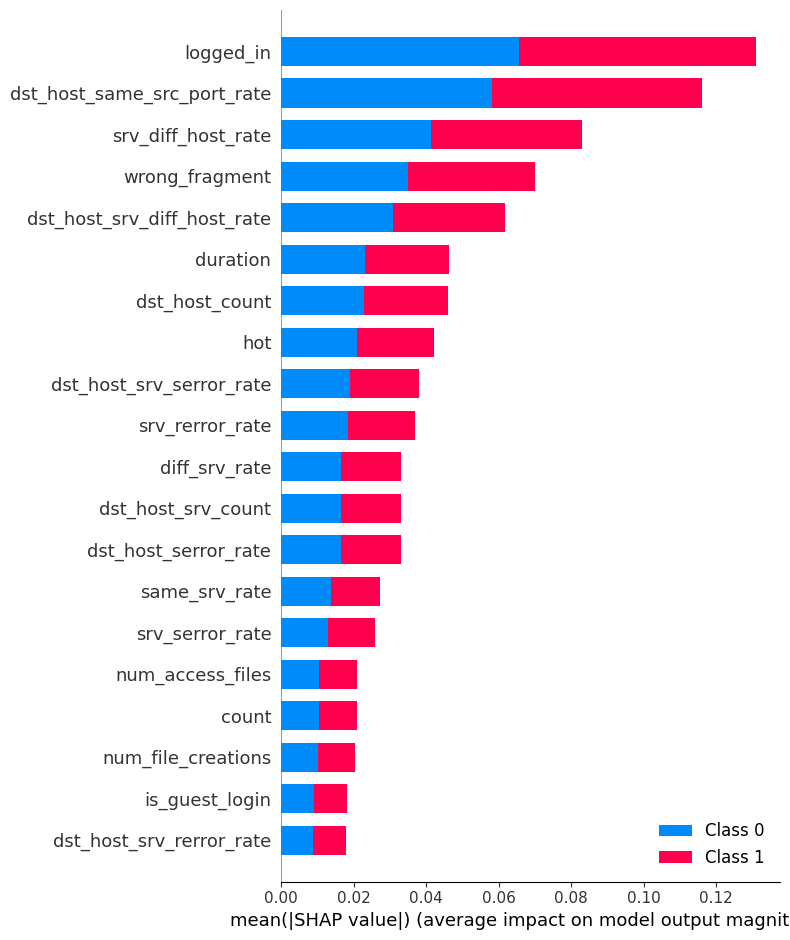

In [66]:
shap.summary_plot(
    _shap_defs,
    selected_features
)

## LOCAL EXPANATION ON NORMAL AND ATTACK

In [75]:
nor_ins_1 = np.random.choice(np.where(np.argmax(ae_detector_cnn.predict(defs_x), axis=1)==0)[0])
atk_ins_1 = np.random.choice(np.where(np.argmax(ae_detector_cnn.predict(defs_x), axis=1)==1)[0])

13/13 [==============================] - 0s 21ms/step


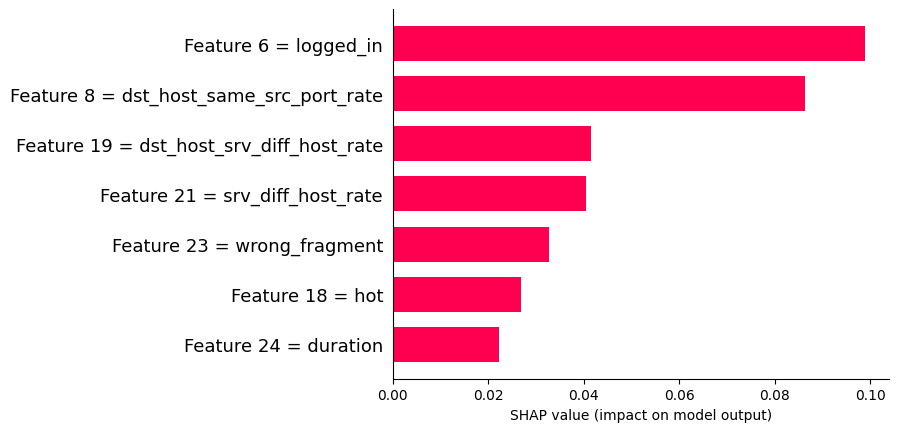

In [80]:
shap.bar_plot(_shap_defs[0][nor_ins_1], selected_features)

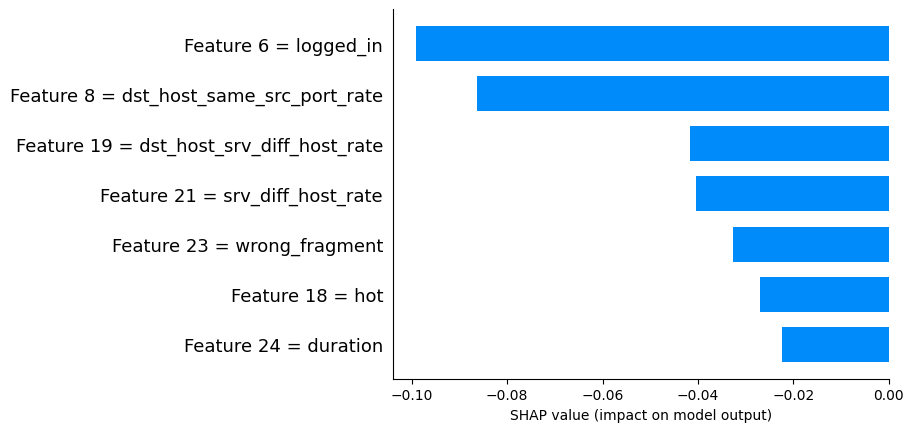

In [81]:
shap.bar_plot(_shap_defs[1][nor_ins_1], selected_features)

## EXPLAIN ON RANDOM TEST